In this notebook written in Februery 2023, I rewrote Mai's code for the channel PN+CD+AWGN. 
In this code the intesities of sqrt(0,1,2,3) are use as the transmitton intensities. 
In the V2 of this code named "IMDD-PN-CD-AWGN-Numpy-2023-3-V2(intensities from AE)", written in March of 2023, 
I will make some changes to work with other intensities gotten from the AE, encoder. *italicized text*

# Functions and libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def binary_batch_to_decimal(Targets):
    """
    This Function Takes a Matrix of the size N * S
    - N number of symbols
    - S Symbol size (#Bits of each symbol )
    and returns a tensor of integers 
    Example: 
    Targets: [[0, 1, 1, 0, 0, 1],
              [1, 0, 1, 1, 0, 1],
              [1, 1, 1, 0, 1, 1]]
    int_Targets: [3, 5, 2, 1, 7]
    """
    int_Targets = np.zeros([len(Targets[:,0])])    
    for j in range(len(Targets[:,0])):
        x=0
        l=len(Targets[0,:])
        for i in range(l):
                x+=Targets[j,i]*2**(l-1-i) 
        int_Targets[j]=x
    return int_Targets.reshape(-1,1)

def tx_PAM_Gen(syst): 
  '''
  This fuction generates PAM symbols 
  input: 
    sys: attribute dictionary of system parameters 
  output:
    ref_Bit: the random bits generated
    ref_PAM: the PAM optical coordiantes (any of [0,1,2,3])
  '''
  PRBS_order = syst.PRBS_order # this variable is gotten from Mai's code. we use random data rather than PRBS
  ModuFormat = syst.PMA_order

  ## bit generation

  rbs = np.random.randint(0,2,(2**PRBS_order,1))

  k_bits = np.log2(ModuFormat)
  Nsymbs = np.floor(np.max(np.size((rbs)))/k_bits)

  ref_BIT = rbs[0:int(Nsymbs*k_bits)]
  
  ## PAM level generation
  bit_matrix = ref_BIT.reshape(int(Nsymbs),int(k_bits))
  tx_vec = binary_batch_to_decimal(bit_matrix)
  

  ref_PAM = tx_vec # pammod(tx_vec,ModuFormat);

  return ref_BIT,ref_PAM

def rectpulse(ref_PAM, syst):
	"""
		Parameters
		------------
		ref_PAM: a sequence of PAM symbols for examplpe for PAM 4 [0,1,2,3] 
    syst: atribute dictionary of the system 
      syst.puls_sps is used here which determines the sample per symbol ratio
		samplesPerSymbol

		Returns
		------------
		outNRZ: NRZ train pulses. 
	"""
	outNRZ = [ref_PAM[i] for i in range(0,len(ref_PAM)) for j in range(0,syst.puls_sps)]
	outNRZ = np.array(outNRZ) 	
	return outNRZ

def add_laser_PN(Data_in_Func, laser): 
  NoiseSamp = np.random.randn(np.max(np.size(Data_in_Func)), 2)
  PNt = (2*np.pi*laser.tx_linewidth*laser.d_t)*np.cumsum(NoiseSamp[:,0]).reshape(-1,1) # considers only firtst dimention of the NoiseSamp
  Data_out_Laser = np.sqrt(laser.power)*Data_in_Func*np.exp(1j*PNt) # transmitter phase noise

  pow_total = np.mean(np.abs(Data_out_Laser)**2);
  # print('******Laser*********');  
  # print('Laser Linewidth = ',(laser.tx_linewidth/1e6),' MHz\n')  
  
  return Data_out_Laser

def add_fiber_CD(Data_in_Func, fiber): 
  w_T = 2*np.pi*np.array(list(np.arange(0,np.max(np.size(Data_in_Func)/2)))+list(np.arange(-np.max(np.size(Data_in_Func))//2,0))).reshape(-1,1)/(np.max(np.size(Data_in_Func))/fiber.BW)
  w = w_T # +min(w_T);  
  HDispersion=np.exp(1j*(fiber.beta2*w**2*fiber.Length)/2+1j*(fiber.beta3*w**3*fiber.Length)/6)  
  # HDispersion=exp(1i*(fiber.beta2*w.^2*fiber.Length)/2);
  # HDispersion2=exp(-1i*(fiber.beta2*w.^2*fiber.Length)/2);
  # HDispersion=HDispersion1.*HDispersion2;
  f_fiber = np.fft.fftshift(w_T/(2e9*np.pi))
  # plt.plot(f_fiber, np.fft.fftshift((fiber.beta2*w**2*fiber.Length)/2+1j*(fier.beta3*w**3*fiber.Length)/6));
  
  # plt.xlabel('frequency (GHz)')
  # plt.ylabel('Fiber Phase Response (fiber.Dispersion caused)')
  # plt.title('Dispersion = {} ps/(nm*km)'.format(fiber.Dispersion))
  # plt.grid(True)
  # plt.show()

  Data_out_Fiber = np.fft.ifft(np.fft.fft(Data_in_Func.reshape(1,-1))*HDispersion.reshape(1,-1))
  alpha=10**(0.05*fiber.Attenuation*fiber.Length);
  # %         Data_out_Fiber=Data_out_Fiber/sqrt(mean(abs(Data_out_Fiber.^2)));
  Data_out_Fiber=Data_out_Fiber.reshape(-1,1)/alpha;

  # print('******Fiber*********');
  # print('Wavelength = {} nm'.format(fiber.lambdaa))
  # print('Fiber Length = {} Km'.format(fiber.Length))
  # print('Dispersion = {} ps/(nm*km)'.format(fiber.Dispersion))
  # print('Attenuation = {} dB/km'.format(fiber.Attenuation))

  pow_total=np.mean(np.abs(Data_out_Fiber)**2);
  # print('***** Totoal Power Fiber Out *****\n      ', pow_total,'\n')
  return Data_out_Fiber

def add_ASE(Data_out, syst):
  noise = ((1/np.sqrt(2)) * (np.random.randn(np.max(Data_out.shape)) + 1j * np.random.randn(np.max(Data_out.shape)))).reshape(-1,1)
  awgn = (np.sqrt(np.mean(np.abs(Data_out)**2)*(10**(-syst.ASE_SNR/10))) * noise)
  Data_out_ASE = Data_out + awgn
  return Data_out_ASE

def PAM_resample_demodulate(Data_out, syst): 
    
  # IMDD constellation generation for to be used for detection 
  PAM_const = (np.sqrt(np.array([0,1,2,3]))).reshape(-1,1)
  PAM_const_norm = PAM_const

  # resampling
  PAM_rx=Data_out[int(syst.puls_sps/2):-1:syst.puls_sps].reshape(1,-1)#sampling at half symbol duration

  # demodulate
  RX = []
  for i in range(np.max(PAM_rx.shape)):
    idx = np.argmin(np.abs(PAM_rx[0,i]-PAM_const_norm**2))       
    RX.append(idx)  
  RX = np.array(RX).reshape(-1,1)
  return RX


#Main

In [ ]:
np.random.seed(123)
if __name__ == "__main__":    
  
  ##############################################################
  # System parameters
  syst = AttrDict()    
  syst.baud_rate  = 10e9
  syst.PMA_order  = 4
  syst.PRBS_order = 19
  syst.roll_off   = 1
  syst.puls_span  = 128
  syst.puls_sps   = 20

  ##############################################################
  # DAC parameters
  DAC = AttrDict()    # DAC parameters
  DAC.sampling_rate = syst.baud_rate*syst.puls_sps
  
  ##############################################################
  # fiber parameters
  fiber = AttrDict()   
  fiber.BW  = DAC.sampling_rate
  fiber.Length      = 3    # [KM]
  fiber.Dispersion  = 18   # [ps/(nm*km)]   (zero at 1310nm  and <=18 at 1550nm)
  fiber.S           = 0    # [ps/(nm^2.km)] Dispersion slope
  fiber.Attenuation = 0    # 0.2; % [dB/km]        (0.34 at 1310nm  and 0.2  at 1550nm)
  fiber.lambdaa     = 1550 # [nm] wavelength
  fiber.beta2       =-1*(fiber.Dispersion*1e-12*1e9*fiber.lambdaa**2*1e-18)/(2*np.pi*3e8)
  fiber.beta3       =-1*(fiber.S*1e-12*1e18*fiber.lambdaa**4*1e-36)/(2*np.pi*3e8)**2

  ##############################################################
  # laser parameters
  laser = AttrDict()
  laser.power = 10**(0/10) # 0 dBm
  laser.tx_linewidth =3e8 #laser line width  
  laser.d_t = 1/(syst.baud_rate)
  laser.std = np.sqrt(2 * np.pi * laser.tx_linewidth * laser.d_t)
  print('Deltha Phi in radians is: ', laser.std)
  

  ##############################################################
  # Swap on SNR
  SER = []
  SNR = []
  for syst.ASE_SNR in range(0,26,1):
    Totla_S_error  = 0
    totoal_symbols = 0
    
    # count at least 100 symbol errors
    while Totla_S_error<=100: 
      ##############################################################
      ## PAM level generation (1-sps)
      ref_BIT,ref_PAM = tx_PAM_Gen(syst)  

      ##############################################################
      # N(syst.puls_sps) sample per symbol PAM generation
      PAM_shaped = rectpulse(ref_PAM, syst) # Data_from_matlab 
      PAM_shaped=np.sqrt(PAM_shaped)

      ##############################################################
      ## laser phase noise
      Data_out_Laser = add_laser_PN(PAM_shaped, laser)
      Data_out = Data_out_Laser #*sqrt(signal_power); # shape is like [N,1]  

      ##############################################################
      # dispersion  
      Data_out_Fiber = add_fiber_CD(Data_out, fiber)
      
      ##############################################################################
      ## AWGN
      Data_out_ASE = add_ASE(Data_out_Fiber, syst)
      
      ##############################################################
      # Phto diod out
      Data_out = np.abs(Data_out_ASE)**2 

      ##############################################################
      #PAM resampling and demodulation
      RX = PAM_resample_demodulate(Data_out, syst)
      
      ##############################################################
      # count symbol errors
      s_errors = np.sum(ref_PAM!= RX)
      totoal_symbols+=np.max(ref_PAM.shape)
      Totla_S_error += s_errors
  
    SER.append(Totla_S_error/totoal_symbols)    
    SNR.append(syst.ASE_SNR)
    print('\t SER for SNR= {} is {}'.format(SNR[-1], SER[-1]))
  
  ##############################################################  
  SNR = np.array(SNR)
  SER = np.array(SER)
  print('SNR range is: \n',SNR)
  print('SER is: \n', SER)


Deltha Phi in radians is:  0.4341607527349606
	 SER for SNR= 0 is 0.6526374816894531
	 SER for SNR= 1 is 0.6301116943359375
	 SER for SNR= 2 is 0.6014480590820312
	 SER for SNR= 3 is 0.5712013244628906
	 SER for SNR= 4 is 0.5369758605957031
	 SER for SNR= 5 is 0.5028266906738281
	 SER for SNR= 6 is 0.46429443359375
	 SER for SNR= 7 is 0.4255027770996094
	 SER for SNR= 8 is 0.3863525390625
	 SER for SNR= 9 is 0.3543243408203125
	 SER for SNR= 10 is 0.32202911376953125
	 SER for SNR= 11 is 0.2958335876464844
	 SER for SNR= 12 is 0.27141571044921875
	 SER for SNR= 13 is 0.2511787414550781
	 SER for SNR= 14 is 0.23152542114257812
	 SER for SNR= 15 is 0.21495437622070312
	 SER for SNR= 16 is 0.19955825805664062
	 SER for SNR= 17 is 0.18275833129882812
	 SER for SNR= 18 is 0.1725921630859375
	 SER for SNR= 19 is 0.1626739501953125
	 SER for SNR= 20 is 0.15251541137695312
	 SER for SNR= 21 is 0.1474609375
	 SER for SNR= 22 is 0.14178085327148438
	 SER for SNR= 23 is 0.13891983032226562
	 SER 

# TST

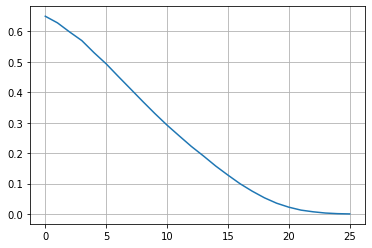

In [ ]:
plt.plot(SER)
plt.grid(True)

In [ ]:
a = (1/np.sqrt(2) * (np.random.randn(np.max(Data_out.shape)))+ 1j * np.random.randn(np.max(Data_out.shape))).reshape(-1,1)
print(a.shape)
np.var(a.imag)

(5242880, 1)


0.9984532693189168

In [ ]:
a = np.array([[0.],[1.],[2.],[3.]]).reshape(1,-1)
print(a.shape)
b = np.array([[1.],[7.],[2.2],[1.5],[6.],[3.],[1.],[3.],[2.]]).reshape(1,-1)
print(b.shape)
x = []
for i in range(b.shape[1]):
  idx = np.argmin(np.abs(b[0,i]-a))     
  x.append(idx)  
x = np.array(x)
print(x)

(1, 4)
(1, 9)
[1 3 2 1 3 3 1 3 2]


## PRBS

In [ ]:
# TremaineConsultingGroup
# Brian Tremaine
# prbs.py
# August 11, 2021
# Prototype PRBS generator
#

#   PRBS15 = x^15 + x^14 + 1   Wikipeda

#           .--->X-------------------------------------------------------->
#           |    |                                                         |
#   bit     |    |                                                         |
#   <-----  D    D    D   D   D   D   D   D   D   D   D   D   D   D   D <--
#
#           bit15          <-------------------------------           bit1
#
#   PRBS7 = x^7 + x^6 + 1
#
#            .--->X------------------------>
#            |    |                         |
#   bit      |    |                         |
#   <------  D    D    D   D   D   D   D <--|
#
#            bit7   <---------------   bit1

from scipy import signal
import matplotlib.pyplot as plt

""" ============ main ======================================
"""
if __name__ == '__main__':   
    
     bit= list()
     start = 1;
     lfsr = start;
     i= 1
     while True:
         fb= ((lfsr>>14) ^ (lfsr>>13) & 1)
         lfsr = ((lfsr<<1) + fb) & (2**15-1) 
         bit.append(fb)
         print (i, lfsr, fb, bin(lfsr) )
         if lfsr==start :
             print('repeat pattern length', i)
             break;
         i = i+1
    
     bit = [float(i) for i in bit]
     
     for i in range(2**15-1):
         bit[i]= 2*(bit[i] - 0.5)
     
     plt.plot(bit); plt.title('PRBS')
     plt.show()
     
     u = signal.correlate(bit,bit)
     plt.plot(u); plt.title('PRBS corr')
     plt.show()
     
     print("done!")